#0. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# 1. IMPORT LIBRARIES + SET BASE DIR + DEVICE


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Base directory for your dataset
base_dir = "/content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/"
print("Available folders:", os.listdir(base_dir))

# DEVICE (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Available folders: ['overview.csv', 'VX', 'WD', 'VY', 'DEM']
Using device: cuda


#2A. LOAD DEM SINGLE

In [ ]:
def load_dem_torch(base_path, sim_id, device=device, verbose=True):
  """
  Loads DEM_simID.txt and returns X, Y, Z as Pytorch tensors

  base_path: folder where DEM exists
  sim_id: simulation ID number
  """

  dem_file = os.path.join(base_path, "DEM", f"DEM_{sim_id}.txt")

  if verbose:
    print(f"\nLoading DEM from: {dem_file}")

  if not os.path.exists(dem_file):
    raise FileNotFoundError(f"DEM file not found: {dem_file}")

  #Shape -> (N, 3)
  #Columns -> X, Y, Z
  data = np.loadtxt(dem_file)

  x_raw = data[:, 0]
  y_raw = data[:, 1]
  z_raw = data[:, 2]

  xs = np.unique(x_raw)
  ys = np.unique(y_raw)

  ny = len(ys)
  nx = len(xs)

  #Reshape into 2D grids
  X = x_raw.reshape(ny, nx)
  Y = y_raw.reshape(ny, nx)
  Z = z_raw.reshape(ny, nx)

  #Convert to torch Tensors on GPU/CPU
  X = torch.from_numpy(X).float().to(device)
  Y = torch.from_numpy(Y).float().to(device)
  Z = torch.from_numpy(Z).float().to(device)

  if verbose:
    print(f"DEM grid shape = {Z.shape}, (ny = {ny}, nx = {nx})")
    print(f"Elevation: {Z.min().item():.2f} to {Z.max().item():.2f}")

  return X, Y, Z

#2B. LOAD DEM BATCH

In [ ]:
def load_dem_batch_torch(base_path, sim_ids, device=device, verbose=True):
    """
    Loads multiple DEMs and stacks them into a batch.

    sim_ids: list of simulation IDs, e.g. [2, 10]
    Returns:
      X_batch, Y_batch, Z_batch with shape (B, ny, nx)
    """

    X_list = []
    Y_list = []
    Z_list = []

    for sid in sim_ids:
        X, Y, Z = load_dem_torch(base_path, sid, device=device, verbose=verbose)
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

    # Stack into batch dimension 0
    X_batch = torch.stack(X_list, dim=0)   # (B, ny, nx)
    Y_batch = torch.stack(Y_list, dim=0)   # (B, ny, nx)
    Z_batch = torch.stack(Z_list, dim=0)   # (B, ny, nx)

    if verbose:
        print(f"\nLoaded batch DEMs with shape: {Z_batch.shape} (B, ny, nx)")

    return X_batch, Y_batch, Z_batch

# 3A. PLOT DEM SINGLE (TENSOR)

In [ ]:
def plot_dem_torch(Z_torch, title="DEM Elevation"):
    """
    Plots a DEM stored as a PyTorch tensor
    """

    # Matplotlib only works with CPU
    Z = Z_torch.detach().cpu().numpy()  # convert to numpy for plotting

    plt.figure(figsize=(8, 6))
    plt.imshow(Z, cmap="terrain", origin="lower")
    plt.colorbar(label="Elevation (m)")
    plt.title(title)
    plt.xlabel("X index")
    plt.ylabel("Y index")
    plt.tight_layout()
    plt.show()

#3B. PLOT DEM BATCH (TENSOR)

In [ ]:
def plot_dem_batch_torch(Z_batch, sim_ids=None, ncols=5, title="DEM Elevation (Batch)"):
    """
    Plots all DEMs in a batch using a grid layout.

    Z_batch: (B, ny, nx) torch tensor
    sim_ids: optional list of simulation IDs for titles
    ncols: number of columns in the grid
    """

    # Convert to CPU numpy for plotting
    if isinstance(Z_batch, torch.Tensor):
      Z_batch = Z_batch.detach().cpu().numpy()

    B = Z_batch.shape[0]
    nrows = int(np.ceil(B / ncols))

    plt.figure(figsize=(4 * ncols, 4 * nrows))

    for b in range(B):
      Z = Z_batch[b]

      plt.subplot(nrows, ncols, b+1)
      plt.imshow(Z, cmap="terrain", origin="lower")
      plt.colorbar(label="Elevation (m)", fraction= 0.046, pad=0.04)

      if sim_ids is not None:
        plt.title(f"DEM (Sim {sim_ids[b]})")
      else:
        plt.title(f"DEM (Batch {b})")

      plt.xlabel("X index")
      plt.ylabel("Y index")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

#4A. LOAD WATER DEPTH (DELFT-3D) AS SINGLE

In [ ]:
def load_wd_torch(base_path, sim_id, target_shape, device=device):
  """
  Loads WD simulation and reshapes into a PyTorch tensor:
  (time, ny, nx)

  Parameters:
  base_path: Path to the dataset folder
  sim_id: Simulation ID number
  target_shape: (ny, nx) taken from DEM
  """
  wd_file = os.path.join(base_path, "WD", f"WD_{sim_id}.txt")

  if not os.path.exists(wd_file):
    raise FileNotFoundError(f"WD file not found: {wd_file}")

  #Loading the data
  WD_np = np.loadtxt(wd_file) #shape (nt, ny*nx)
  nt, n_flat = WD_np.shape

  # Extract target shape
  ny, nx = target_shape
  assert n_flat == ny*nx, f"WD grid mismatch: expected {ny*nx}, got {n_flat}"

  #Convert to PyTorch and reshape
  WD = torch.from_numpy(WD_np).float().reshape(nt, ny, nx).to(device)

  print(f"WD tensor shape = {WD.shape} (time, ny, nx)")
  return WD


# 4B. LOAD WATER DEPTH (DELFt-3D) AS BATCH

In [ ]:
def load_wd_batch_torch(base_path, sim_ids, target_shape, device=device, verbose=True):
    """
    Loads WD for multiple simulations and stacks into a batch.

    Returns:
      WD_batch: (B, time, ny, nx)

    Assumes:
      - All sims have the same nt (time steps) and same (ny, nx)
    """
    WD_list = []
    nt_ref = None

    for sid in sim_ids:
        WD = load_wd_torch(base_path, sid, target_shape, device=device)  # (nt, ny, nx)

        # check same nt across sims
        if nt_ref is None:
            nt_ref = WD.shape[0]
        else:
            assert WD.shape[0] == nt_ref, f"Time steps mismatch: expected {nt_ref}, got {WD.shape[0]} for sim {sid}"

        WD_list.append(WD)

    WD_batch = torch.stack(WD_list, dim=0)  # (B, nt, ny, nx)

    if verbose:
        print(f"WD batch shape = {WD_batch.shape} (B, time, ny, nx)")

    return WD_batch


# 5A. PLOT FINAL WATER DEPTH (DELFT-3D WD)

In [ ]:
def plot_final_wd_torch(WD_torch, title="Final Delft-3D Depth"):
    """
    Plots the final water depth timestep
    """

    # Convert last timestep to CPU numpy
    final_depth = WD_torch[-1].detach().cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(final_depth, cmap="Blues", origin="lower")
    plt.colorbar(label="Water depth (m)")
    plt.title(title)
    plt.xlabel("X index")
    plt.ylabel("Y index")
    plt.tight_layout()
    plt.show()


#5B. PLOT FINAL WATER DEPTH (DELFT-3D WD) BATCH

In [ ]:
def plot_final_wd_batch_torch(WD_batch, sim_ids=None, ncols=4, suptitle="Final WD Depth (Batch)"):
    """
    WD_batch: (B, time, ny, nx)
    """

    B = WD_batch.shape[0]
    nrows = int(np.ceil(B / ncols))

    plt.figure(figsize=(4 * ncols, 4 * nrows))

    for b in range(B):
        final_depth = WD_batch[b, -1].detach().cpu().numpy()

        plt.subplot(nrows, ncols, b + 1)
        plt.imshow(final_depth, cmap="Blues", origin="lower", vmin=0)
        plt.colorbar(label="Depth (m)", fraction=0.046, pad=0.04)

        if sim_ids is not None:
            plt.title(f"WD (Sim {sim_ids[b]})")
        else:
            plt.title(f"WD (Batch {b})")

        plt.xlabel("X index")
        plt.ylabel("Y index")

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

#6. CREATE BREACH MASK

In [ ]:
def create_breach_mask_batch(Z_batch, breach_list, device=device):
    """
    Create a batch of breach masks.

    Z_batch: (B, ny, nx)
    breach_list: list of tuples (row_start, row_end, col_start, col_end)
                 length = B
    Returns:
      mask_batch: (B, ny, nx) bool tensor
    """
    B, ny, nx = Z_batch.shape
    mask_batch = torch.zeros((B, ny, nx), dtype=torch.bool, device=device)

    assert len(breach_list) == B, "breach_list length must match batch size B"

    for b in range(B):
        row_start, row_end, col_start, col_end = breach_list[b]
        mask_batch[b, row_start:row_end+1, col_start:col_end+1] = True

    return mask_batch

# 7. PLOT DEM WITH THE BREACH

In [ ]:
def plot_breach_on_dem(Z, mask, title="Breach Location on DEM"):
    """
    Plot DEM with the breach/inflow mask overlay.
    Accepts both PyTorch and Numpy arrays
    """
    # Convert to CPU Numpy for plotting
    if isinstance(Z, torch.Tensor):
        Z = Z.detach().cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()

    plt.figure(figsize=(10, 8))

    # Plot DEM
    plt.imshow(Z, cmap="terrain", origin="lower")
    plt.colorbar(label="Elevation (m)")

    # Overlay breach mask
    breach_y, breach_x = np.where(mask)
    plt.scatter(breach_x, breach_y, color="red", s=20, label="Breach Cells")

    plt.title(title, fontsize=14)
    plt.xlabel("X index")
    plt.ylabel("Y index")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 8. NEIGHBOUR HELPER FOR BATCHED 2D FIELDS

In [ ]:
def get_neighbors_2d_batched(WL):
    """
    WL: (B, ny, nx) tensor of water levels.

    Returns:
      WL_up, WL_dn, WL_lt, WL_rt   (each shape: (B, ny, nx))
    """

    # Up: shift along y (dim=1)
    WL_up = torch.cat([WL[:, :1, :], WL[:, :-1, :]], dim=1)

    # Down: shift along y (dim=1)
    WL_dn = torch.cat([WL[:, 1:, :], WL[:, -1:, :]], dim=1)

    # Left: shift along x (dim=2)
    WL_lt = torch.cat([WL[:, :, :1], WL[:, :, :-1]], dim=2)

    # Right: shift along x (dim=2)
    WL_rt = torch.cat([WL[:, :, 1:], WL[:, :, -1:]], dim=2)

    return WL_up, WL_dn, WL_lt, WL_rt

# 10. CELLULAR AUTOMATA FLOOD MODEL (BATCHED)

In [ ]:
def run_ca_flood_torch_batch(
    Z_batch,
    dx,
    t_end,
    inflow_mask_batch,
    Q_in=50.0,
    n_manning=0.023,
    theta=0.7,
    CFL=1.0,
    dt_min=0.5,
    dt_max=15.0,
    depth_threshold=0.01,
):
    """
    Batched PyTorch version of run_ca_swegnn_torch.

    Parameters
    ----------
    Z_batch : (B, ny, nx) torch.Tensor
        Ground elevation for each simulation in the batch.
    dx : float
        Grid resolution (m).
    t_end : float
        Final time (s).
    inflow_mask_batch : (B, ny, nx) boolean torch.Tensor
        True where inflow occurs for each simulation.
    Q_in : float
        Constant inflow discharge [m³/s] (same for all sims, for now).
    n_manning : float
        Manning roughness coefficient (same for all sims, for now).
    theta, CFL, dt_min, dt_max, depth_threshold : as before.

    Returns
    -------
    sample_times_out : np.ndarray of shape (nt,)
    depth_samples_batch : torch.Tensor of shape (nt, B, ny, nx)
        Water depths over time for each simulation in the batch.
    """

    # ------------------------------------------------------------
    # 1. Ensure tensors on device
    # ------------------------------------------------------------
    if not isinstance(Z_batch, torch.Tensor):
        Z_batch = torch.from_numpy(np.asarray(Z_batch, dtype=np.float32))
    Z_batch = Z_batch.to(device=device, dtype=torch.float32)

    if not isinstance(inflow_mask_batch, torch.Tensor):
        inflow_mask_batch = torch.from_numpy(
            np.asarray(inflow_mask_batch, dtype=bool)
        )
    inflow_mask_batch = inflow_mask_batch.to(device=device, dtype=torch.bool)

    B, ny, nx = Z_batch.shape
    A = dx * dx   # cell area

    # Initially dry bed
    d = torch.zeros_like(Z_batch, device=device)  # (B, ny, nx)
    WL = Z_batch.clone()                          # (B, ny, nx)

    # ------------------------------------------------------------
    # 2. Precompute neighbour topography (fixed in time)
    # ------------------------------------------------------------
    Z_up  = torch.cat([Z_batch[:, :1, :], Z_batch[:, :-1, :]], dim=1)
    Z_dn  = torch.cat([Z_batch[:, 1:, :], Z_batch[:, -1:, :]], dim=1)
    Z_lt  = torch.cat([Z_batch[:, :, :1], Z_batch[:, :, :-1]], dim=2)
    Z_rt  = torch.cat([Z_batch[:, :, 1:], Z_batch[:, :, -1:]], dim=2)

    # ------------------------------------------------------------
    # 3. Output sampling setup
    # ------------------------------------------------------------
    t = 0.0
    step = 0

    dt_output = 1800.0  # 30 min
    sample_times = []
    depth_samples = []
    next_sample_time = 0.0

    # ------------------------------------------------------------
    # 4. Manning + Critical Velocity Cap (torch version)
    # ------------------------------------------------------------
    g = 9.81

    def vcap(d_if, slope):
        slope = torch.clamp(slope, min=1e-4)
        d_if  = torch.clamp(d_if,  min=1e-4)

        v_m = (1.0 / n_manning) * (d_if ** (2.0 / 3.0)) * torch.sqrt(slope)
        v_c = torch.sqrt(g * d_if)

        return torch.minimum(v_m, v_c)

    # ------------------------------------------------------------
    # 5. Compute time step – CFL based (batched)
    # ------------------------------------------------------------
    def compute_dt_batched(WL):
        WL_up, WL_dn, WL_lt, WL_rt = get_neighbors_2d_batched(WL)

        # interfacial depths
        d_if_up = torch.clamp(
            torch.maximum(WL, WL_up) - torch.maximum(Z_batch, Z_up), min=0.0
        )
        d_if_dn = torch.clamp(
            torch.maximum(WL, WL_dn) - torch.maximum(Z_batch, Z_dn), min=0.0
        )
        d_if_lt = torch.clamp(
            torch.maximum(WL, WL_lt) - torch.maximum(Z_batch, Z_lt), min=0.0
        )
        d_if_rt = torch.clamp(
            torch.maximum(WL, WL_rt) - torch.maximum(Z_batch, Z_rt), min=0.0
        )

        # surface slopes
        dWL_up = torch.clamp(WL - WL_up, min=0.0) / dx
        dWL_dn = torch.clamp(WL - WL_dn, min=0.0) / dx
        dWL_lt = torch.clamp(WL - WL_lt, min=0.0) / dx
        dWL_rt = torch.clamp(WL - WL_rt, min=0.0) / dx

        # velocities
        v_up = vcap(d_if_up, dWL_up)
        v_dn = vcap(d_if_dn, dWL_dn)
        v_lt = vcap(d_if_lt, dWL_lt)
        v_rt = vcap(d_if_rt, dWL_rt)

        vmax = torch.stack([
            v_up.max(),
            v_dn.max(),
            v_lt.max(),
            v_rt.max(),
            torch.tensor(1e-10, device=device)
        ]).max().item()

        dt = CFL * dx / vmax
        return dt

    # ============================================================
    # MAIN LOOP (BATCHED)
    # ============================================================
    while t < t_end:

        # wet fraction over whole batch
        wet_cells = torch.count_nonzero(d > depth_threshold).item()
        wet_fraction = wet_cells / d.numel()

        # dt choice
        if wet_fraction < 0.002:
            dt = dt_max
        else:
            dt = compute_dt_batched(WL)

        if t + dt > t_end:
            dt = t_end - t

        # CONSTANT INFLOW (same Q_in for all sims)
        if Q_in > 0.0:
            vol_in = Q_in * dt
            dh_in  = vol_in / A
            d[inflow_mask_batch] += dh_in
            WL[inflow_mask_batch] = Z_batch[inflow_mask_batch] + d[inflow_mask_batch]

        # NEIGHBOUR WATER LEVELS
        WL_up, WL_dn, WL_lt, WL_rt = get_neighbors_2d_batched(WL)

        # interfacial depths
        d_if_up = torch.clamp(
            torch.maximum(WL, WL_up) - torch.maximum(Z_batch, Z_up), min=0.0
        )
        d_if_dn = torch.clamp(
            torch.maximum(WL, WL_dn) - torch.maximum(Z_batch, Z_dn), min=0.0
        )
        d_if_lt = torch.clamp(
            torch.maximum(WL, WL_lt) - torch.maximum(Z_batch, Z_lt), min=0.0
        )
        d_if_rt = torch.clamp(
            torch.maximum(WL, WL_rt) - torch.maximum(Z_batch, Z_rt), min=0.0
        )

        # water surface slopes
        dWL_up = torch.clamp(WL - WL_up, min=0.0) / dx
        dWL_dn = torch.clamp(WL - WL_dn, min=0.0) / dx
        dWL_lt = torch.clamp(WL - WL_lt, min=0.0) / dx
        dWL_rt = torch.clamp(WL - WL_rt, min=0.0) / dx

        # velocities
        v_up = vcap(d_if_up, dWL_up)
        v_dn = vcap(d_if_dn, dWL_dn)
        v_lt = vcap(d_if_lt, dWL_lt)
        v_rt = vcap(d_if_rt, dWL_rt)

        # fluxes
        F_up = v_up * d_if_up * dx * dt
        F_dn = v_dn * d_if_dn * dx * dt
        F_lt = v_lt * d_if_lt * dx * dt
        F_rt = v_rt * d_if_rt * dx * dt

        # volume in each cell
        V = d * A
        total_out = F_up + F_dn + F_lt + F_rt

        # prevent more outflow than water available
        mask_over = total_out > V
        if mask_over.any():
            scale = V / torch.clamp(total_out, min=1e-12)
            F_up = F_up * scale
            F_dn = F_dn * scale
            F_lt = F_lt * scale
            F_rt = F_rt * scale

        # net volume change dV (B, ny, nx)
        dV = torch.zeros_like(V, device=device)

        # up-down fluxes
        dV -= F_up
        dV[:, 1:, :] += F_dn[:, :-1, :]
        dV -= F_dn
        dV[:, :-1, :] += F_up[:, 1:, :]

        # left-right fluxes
        dV -= F_lt
        dV[:, :, 1:] += F_rt[:, :, :-1]
        dV -= F_rt
        dV[:, :, :-1] += F_lt[:, :, 1:]

        # update depth with relaxation
        d = torch.clamp(d + theta * (dV / A), min=0.0)
        WL = Z_batch + d

        t += dt
        step += 1

        if t >= next_sample_time:
            sample_times.append(t)
            depth_samples.append(d.clone())  # (B, ny, nx)
            next_sample_time += dt_output

    sample_times_out = np.array(sample_times, dtype=float)
    depth_samples_batch = torch.stack(depth_samples, dim=0)  # (nt, B, ny, nx)

    return sample_times_out, depth_samples_batch


# 11. PLOT CA FINAL FLOOD DEPTH MAP (SINGLE FIELD)

In [ ]:
def plot_final_depth(water_depth, sim_id):
    """
    Plot final flood depth map.

    Parameters:
    -----------
    water_depth: (time, ny, nx)
      - Water depth over time given by CA
    sim_id: simulation ID
    """

    # Check if tensor or numpy array
    if isinstance(water_depth, torch.Tensor):
        wd_cpu = water_depth.detach().cpu().numpy()
    else:
        wd_cpu = water_depth  # already in numpy

    # wd_cpu shape is (nt, ny, nx)
    final_depth = wd_cpu[-1]  # Final Time Step

    plt.figure(figsize=(10, 8))

    # Plot the final water depth map
    im = plt.imshow(final_depth, cmap="Blues", origin="lower", vmin=0)
    plt.colorbar(im, label="Water Depth (m)")

    # Flood Statistics
    wet_cells = np.sum(final_depth > 0.01)    # count wet cells
    total_cells = final_depth.size            # total grid cells
    max_depth = final_depth.max()             # maximum flood depth

    print(f"Simulation {sim_id} - Statistics")
    print(f"Wet cells: {wet_cells} / {total_cells}")
    print(f"Max depth: {max_depth:.3f} m")

    plt.title(f"Final Flood Depth Map (Sim {sim_id})")
    plt.xlabel("X index")
    plt.ylabel("Y index")
    plt.tight_layout()
    plt.show()


# 12. PLOT CA FINAL FLOOD DEPTH VS DELFT-3D FINAL FLOOD DEPTH

In [ ]:
def plot_CA_vs_WD(final_CA_depth, final_WD_depth, title="CA vs Delft-3D Final Flood Depth"):
    """
    Plot side-by-side comparison of final CA flood depth and Delft-3D WD depth.
    """

    # Convert inputs to CPU Numpy arrays
    if isinstance(final_CA_depth, torch.Tensor):
        final_CA_depth = final_CA_depth.detach().cpu().numpy()

    if isinstance(final_WD_depth, torch.Tensor):
        final_WD_depth = final_WD_depth.detach().cpu().numpy()

    # Use a common max depth range for consistency
    vmax = max(final_CA_depth.max(), final_WD_depth.max())

    plt.figure(figsize=(14, 6))

    # CA Flood Depth
    plt.subplot(1, 2, 1)
    plt.imshow(final_CA_depth, origin="lower", cmap="Blues", vmin=0, vmax=vmax)
    plt.colorbar(label="Depth (m)")
    plt.title("Final CA Flood Depth")
    plt.xlabel("X index")
    plt.ylabel("Y index")

    # Delft-3D Flood Depth
    plt.subplot(1, 2, 2)
    plt.imshow(final_WD_depth, origin="lower", cmap="Blues", vmin=0, vmax=vmax)
    plt.colorbar(label="Depth (m)")
    plt.title("Final Delft-3D WD Depth")
    plt.xlabel("X index")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()





#13. GRID PLOTTING HELPERS

In [ ]:
def plot_batch_maps(maps_batch, sim_ids=None, ncols=4, cmap="terrain", suptitle="Batch Plot", vmin=None, vmax=None):
    """
    maps_batch: (B, ny, nx) torch tensor OR numpy array
    """
    if isinstance(maps_batch, torch.Tensor):
        maps_batch = maps_batch.detach().cpu().numpy()

    B = maps_batch.shape[0]
    nrows = int(np.ceil(B / ncols))

    plt.figure(figsize=(4 * ncols, 4 * nrows))

    for b in range(B):
        plt.subplot(nrows, ncols, b + 1)
        plt.imshow(maps_batch[b], cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.046, pad=0.04)

        if sim_ids is not None:
            plt.title(f"Sim {sim_ids[b]}")
        else:
            plt.title(f"Batch {b}")

        plt.xlabel("X index")
        plt.ylabel("Y index")

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


def final_ca_depth_from_samples(depth_samples_batch):
    """
    depth_samples_batch: (nt_saved, B, ny, nx)
    returns: (B, ny, nx) final depth
    """
    return depth_samples_batch[-1]


#14. CSI MODULE

In [ ]:
def compute_csi_batch(pred_depth_batch, obs_depth_batch, threshold=0.05, eps=1e-9, device=device):
  """
  Compute Critical Success Index (CSI) for a batch of flood maps.

  pred_depth_batch: (B, ny, nx) torch tensor
  obs_depth_batch: (B, ny, nx) torch tensor
  threshold: flood/no-flood threshold in meters (default 0.05 m)
  eps: small number to avoid divide by zero

  Returns:
    CSI: (B, ) torch tensor
    tp, fp, fn: (B, ) torch tensors (counts per simulation)
  """

  # Ensure torch + correct device
  if not isinstance(pred_depth_batch, torch.Tensor):
    pred_depth_batch = torch.from_numpy(np.asarray(pred_depth_batch))

  if not isinstance(obs_depth_batch, torch.Tensor):
    obs_depth_batch = torch.from_numpy(np.asarray(obs_depth_batch))

  pred_depth_batch = pred_depth_batch.to(device=device, dtype=torch.float32)
  obs_depth_batch = obs_depth_batch.to(device=device, dtype=torch.float32)

  #Binary flood masks
  pred_flood = pred_depth_batch >= threshold
  obs_flood = obs_depth_batch >= threshold

  #Counts per simulation (sum over ny, nx)
  tp = (pred_flood & obs_flood).sum(dim=(1, 2)).float()
  fp = (pred_flood & (~obs_flood)).sum(dim=(1, 2)).float()
  fn = ((~pred_flood) & obs_flood).sum(dim=(1, 2)).float()

  csi = tp / (tp + fp + fn + eps)

  return csi, tp, fp, fn

def print_csi_report(sim_ids, csi, tp, fp, fn, threshold):
  """
  Prints a clean per-simulation CSI report
  """
  csi_cpu = csi.detach().cpu().numpy()
  tp_cpu = tp.detach().cpu().numpy()
  fp_cpu = fp.detach().cpu().numpy()
  fn_cpu = fn.detach().cpu().numpy()

  print("\n================ CSI Report (threshold = {0.05} m) ================")
  print("SimID |    CSI   |    TP    |    FP    |    FN")
  print("---------------------------------------------------------------")
  for i, sid in enumerate(sim_ids):
    print(f"{sid:5d} | {csi_cpu[i]:7.3f} | {tp_cpu[i]:7.0f} | {fp_cpu[i]:7.0f} | {fn_cpu[i]:7.0f}")
  print("---------------------------------------------------------------")
  print(f"Mean CSI over batch: {csi_cpu.mean():.3f}")
  print("===============================================================\n")

#15. PLOT DIFFERENCE MAP BATCH
- Compute the difference, per grid cell:
CA - Delft-3D
- Postive (red) -> CA overpredicts depth
- Negative (blue) -> CA underpredicts depth
- Zero (white) -> perfect match

In [ ]:
def plot_difference_map_batch(
    ca_depth_batch,
    wd_depth_batch,
    sim_ids=None,
    ncols=4,
    vmax_abs=None,
    title="Difference Map (CA − Delft-3D)"
):
    """
    Plot batched difference maps: CA depth − Delft-3D depth.

    ca_depth_batch: (B, ny, nx)
    wd_depth_batch: (B, ny, nx)
    """

    # Convert to numpy if needed
    if isinstance(ca_depth_batch, torch.Tensor):
        ca_depth_batch = ca_depth_batch.detach().cpu().numpy()
    if isinstance(wd_depth_batch, torch.Tensor):
        wd_depth_batch = wd_depth_batch.detach().cpu().numpy()

    diff_batch = ca_depth_batch - wd_depth_batch  # (B, ny, nx)

    B = diff_batch.shape[0]
    nrows = int(np.ceil(B / ncols))

    # Symmetric color scale
    if vmax_abs is None:
        vmax_abs = np.percentile(np.abs(diff_batch), 95)

    plt.figure(figsize=(4 * ncols, 4 * nrows))

    for b in range(B):
        plt.subplot(nrows, ncols, b + 1)
        im = plt.imshow(
            diff_batch[b],
            origin="lower",
            cmap="RdBu_r",
            vmin=-vmax_abs,
            vmax=vmax_abs
        )
        plt.colorbar(im, fraction=0.046, pad=0.04)

        if sim_ids is not None:
            plt.title(f"Sim {sim_ids[b]}")
        else:
            plt.title(f"Batch {b}")

        plt.xlabel("X index")
        plt.ylabel("Y index")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# 16. MODULAR BATCH RUNNER + GRID PLOTTING

In [ ]:
def run_batch_flood_pipeline(
    base_dir,
    sim_ids,
    dx,
    t_end,
    Q_in=50.0,
    n_manning=0.023,
    theta=0.7,
    CFL=1.0,
    dt_min=0.5,
    dt_max=15.0,
    depth_threshold=0.01,
    device=device,
    plot_everything=True,
    ncols=4,
    csi_threshold=0.05,
    compute_csi=True
):
    """
    1) Loads DEMs in batch
    2) Asks user breach rectangle per sim (row_start,row_end,col_start,col_end)
    3) Creates breach masks in batch
    4) Runs CA solver in batch using run_ca_flood_torch_batch
    5) Loads WD ground-truth in batch
    6) Plots DEM / WD / CA final depth in grids
    7) Computes CSI at threshold = 0.05 m (default)
    8) Plots Difference Map: CA - Delft-3D (final)
    """

    # ------------------------------------------------------------
    # (A) Load DEM batch
    # ------------------------------------------------------------
    Xb, Yb, Zb = load_dem_batch_torch(base_dir, sim_ids, device=device, verbose=True)
    B, ny, nx = Zb.shape
    print(f"\nBatch size B = {B}, grid = ({ny}, {nx})")

    # ------------------------------------------------------------
    # (B) Ask breach rectangles from user (interactive)
    # ------------------------------------------------------------
    breach_list = []
    print("\nEnter breach rectangle per simulation:")
    print("Format: row_start row_end col_start col_end")
    print("Example: 0 3 0 7\n")

    for sid in sim_ids:
        txt = input(f"Sim {sid} breach (row_start row_end col_start col_end): ")
        parts = txt.strip().split()
        assert len(parts) == 4, "Please enter exactly 4 integers."

        row_start = int(parts[0])
        row_end   = int(parts[1])
        col_start = int(parts[2])
        col_end   = int(parts[3])

        breach_list.append((row_start, row_end, col_start, col_end))

    # ------------------------------------------------------------
    # (C) Create breach masks in batch
    # ------------------------------------------------------------
    mask_batch = create_breach_mask_batch(Zb, breach_list, device=device)  # (B, ny, nx)

    # ------------------------------------------------------------
    # (D) Run CA solver in batch
    # ------------------------------------------------------------
    sample_times, depth_samples_batch = run_ca_flood_torch_batch(
        Z_batch=Zb,
        dx=dx,
        t_end=t_end,
        inflow_mask_batch=mask_batch,
        Q_in=Q_in,
        n_manning=n_manning,
        theta=theta,
        CFL=CFL,
        dt_min=dt_min,
        dt_max=dt_max,
        depth_threshold=depth_threshold,
    )
    # depth_samples_batch: (nt_saved, B, ny, nx)

    final_ca_batch = final_ca_depth_from_samples(depth_samples_batch)  # (B, ny, nx)

    # ------------------------------------------------------------
    # (E) Load WD ground-truth in batch
    # ------------------------------------------------------------
    WD_batch = load_wd_batch_torch(base_dir, sim_ids, target_shape=(ny, nx), device=device, verbose=True)
    # WD_batch: (B, nt, ny, nx)

    # Always define final_wd_batch (used by CSI + difference map)
    final_wd_batch = WD_batch[:, -1]  # (B, ny, nx)

    # ------------------------------------------------------------
    # (E2) COMPUTE CSI
    # ------------------------------------------------------------
    csi = tp = fp = fn = None
    if compute_csi:
        csi, tp, fp, fn = compute_csi_batch(
            pred_depth_batch=final_ca_batch,
            obs_depth_batch=final_wd_batch,
            threshold=csi_threshold,
            device=device
        )
        print_csi_report(sim_ids, csi, tp, fp, fn, threshold=csi_threshold)

    # ------------------------------------------------------------
    # (F) Plot grids + Difference Map
    # ------------------------------------------------------------
    if plot_everything:

        # DEM
        plot_batch_maps(Zb, sim_ids=sim_ids, ncols=ncols, cmap="terrain", suptitle="DEM (Batch)")

        # WD final (ground truth)
        plot_final_wd_batch_torch(WD_batch, sim_ids=sim_ids, ncols=ncols, suptitle="Final WD (Ground Truth)")

        # CA final
        plot_batch_maps(
            final_ca_batch,
            sim_ids=sim_ids,
            ncols=ncols,
            cmap="Blues",
            suptitle="Final CA Depth (Batch)",
            vmin=0
        )

        # Difference map (CA - Delft-3D)
        plot_difference_map_batch(
            ca_depth_batch=final_ca_batch,
            wd_depth_batch=final_wd_batch,
            sim_ids=sim_ids,
            ncols=ncols,
            title="Difference Map: CA − Delft-3D (Final)"
        )

    # ------------------------------------------------------------
    # (G) Return everything useful
    # ------------------------------------------------------------
    out = {
        "sim_ids": sim_ids,
        "Z_batch": Zb,
        "mask_batch": mask_batch,
        "sample_times": sample_times,
        "depth_samples_batch": depth_samples_batch,
        "final_ca_batch": final_ca_batch,
        "WD_batch": WD_batch,
        "final_wd_batch": final_wd_batch,   # handy for later
    }

    if compute_csi:
        out["CSI"] = csi
        out["TP"] = tp
        out["FP"] = fp
        out["FN"] = fn
        out["csi_threshold"] = csi_threshold

    return out


#EXAMPLE WORKFLOW


Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_1.txt
DEM grid shape = torch.Size([64, 64]), (ny = 64, nx = 64)
Elevation: -3.44 to 3.04

Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_2.txt
DEM grid shape = torch.Size([64, 64]), (ny = 64, nx = 64)
Elevation: -3.49 to 4.46

Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_3.txt
DEM grid shape = torch.Size([64, 64]), (ny = 64, nx = 64)
Elevation: -1.87 to 2.16

Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_4.txt
DEM grid shape = torch.Size([64, 64]), (ny = 64, nx = 64)
Elevation: -0.73 to 0.84

Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_5.txt
DEM grid shape = torch.Size([64, 64]), (ny = 64, nx = 64)


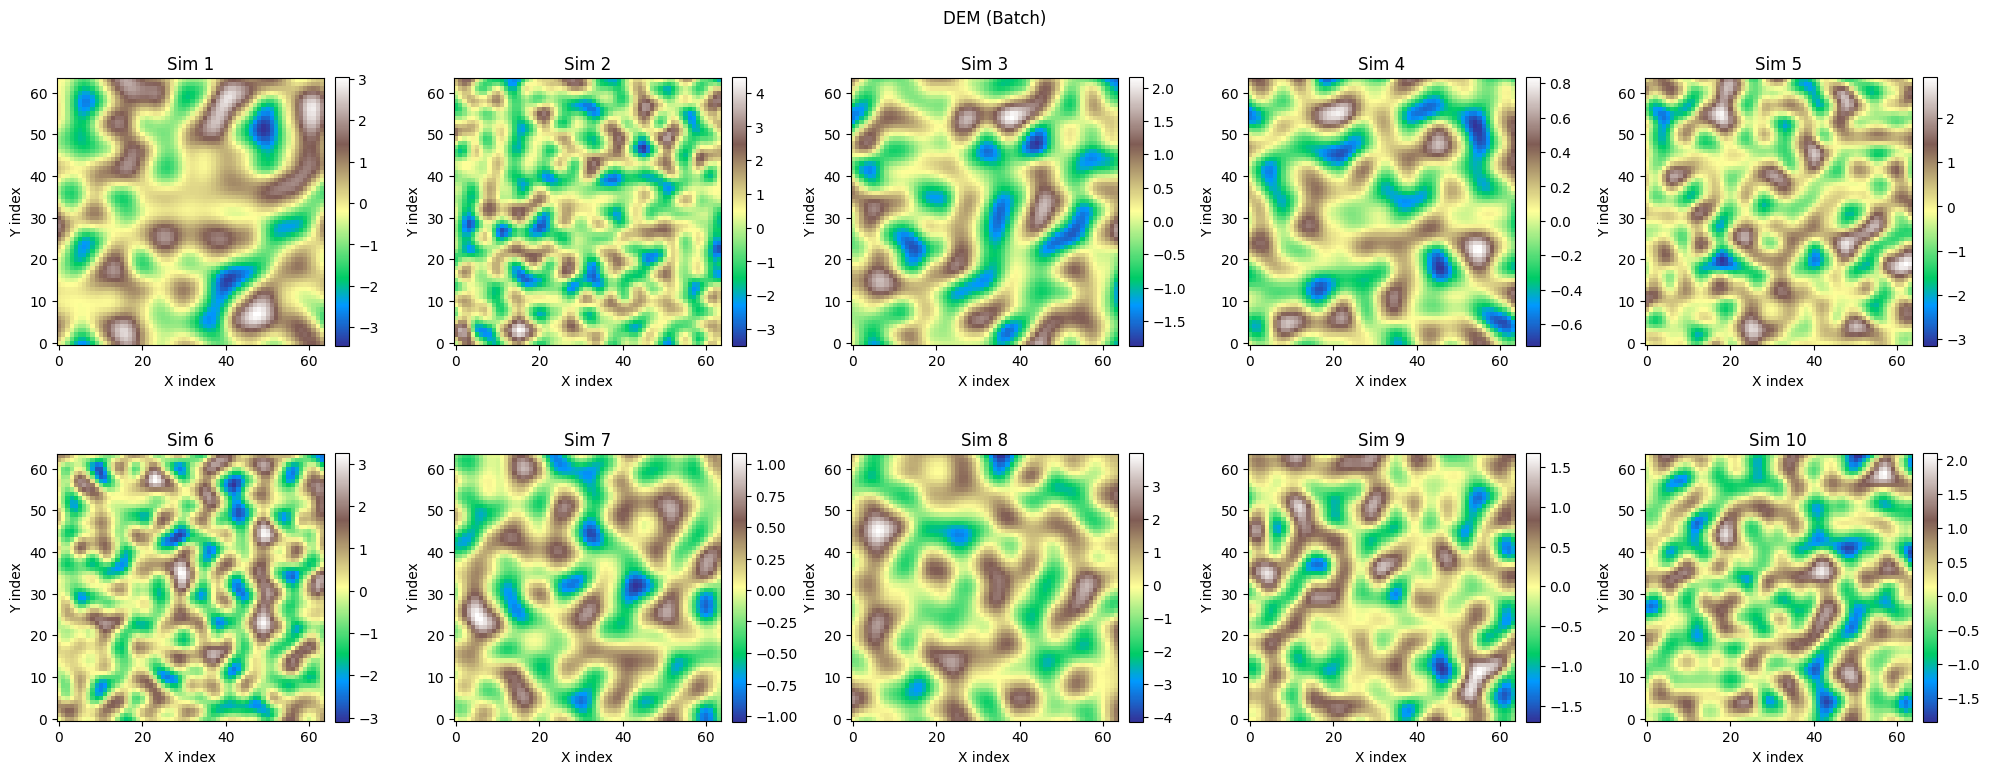

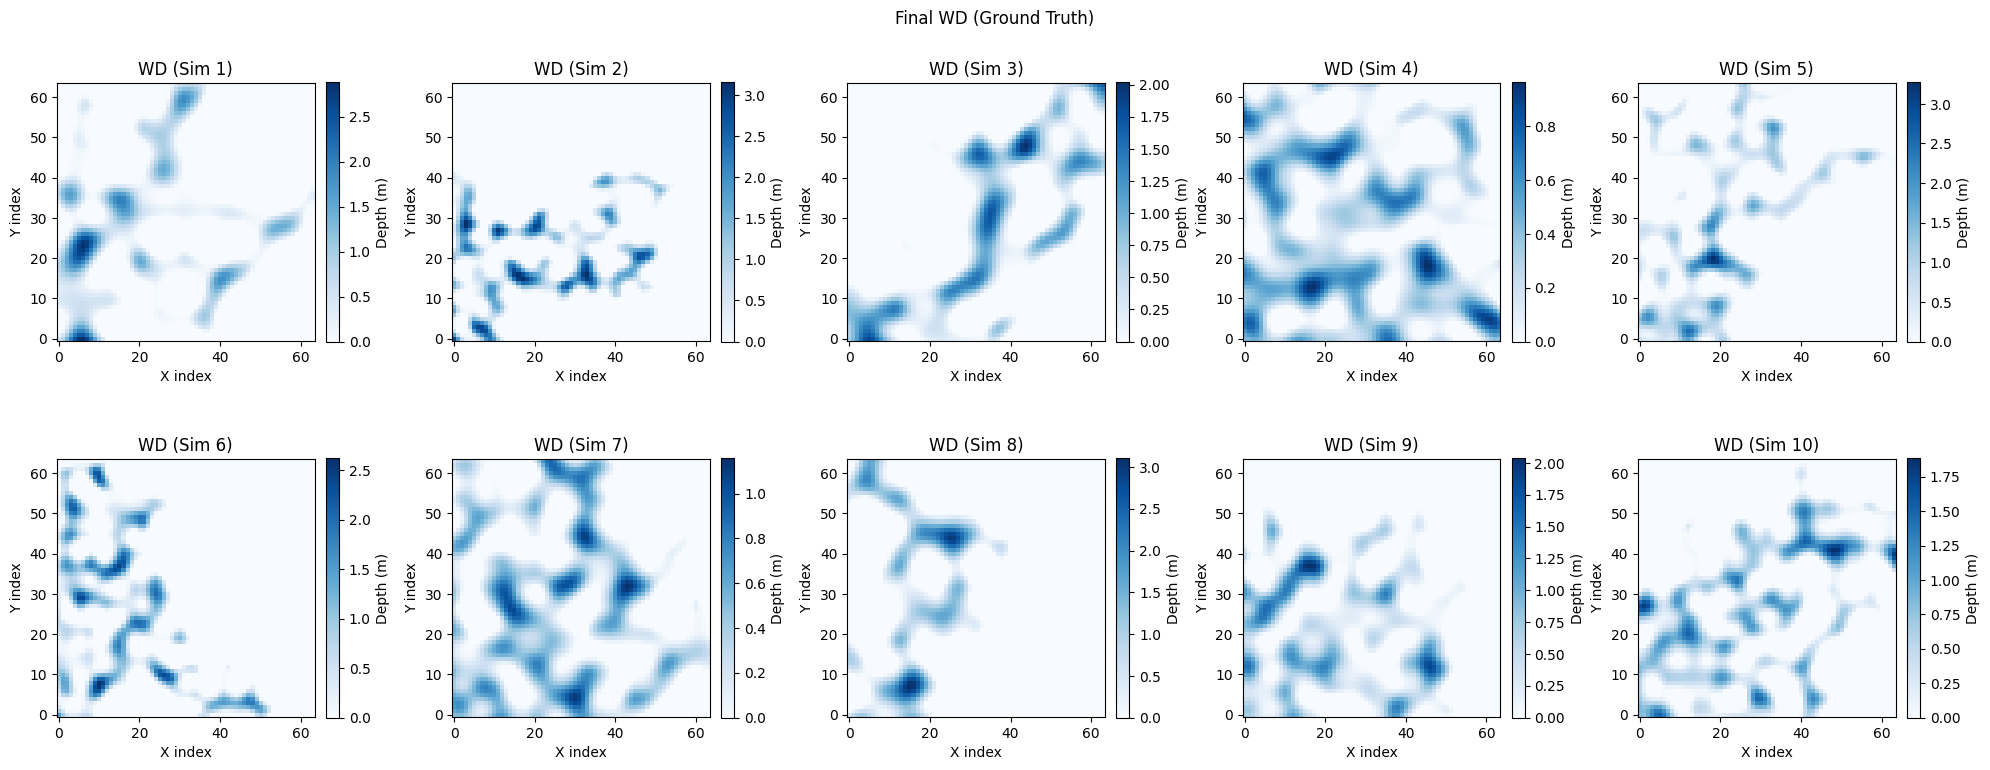

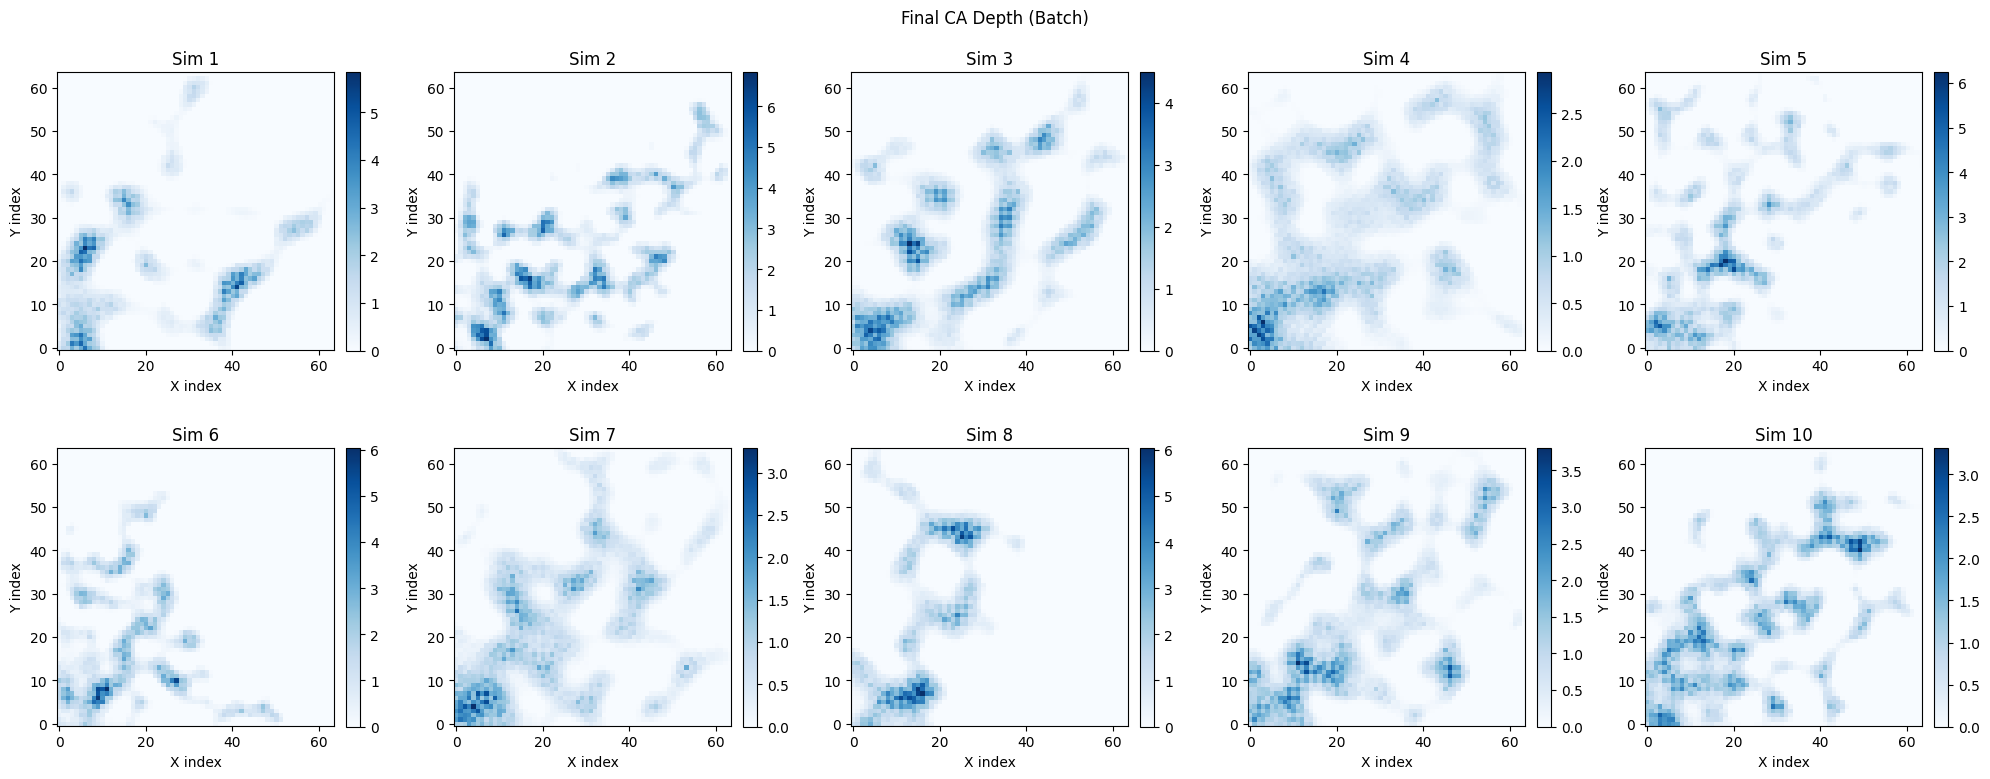

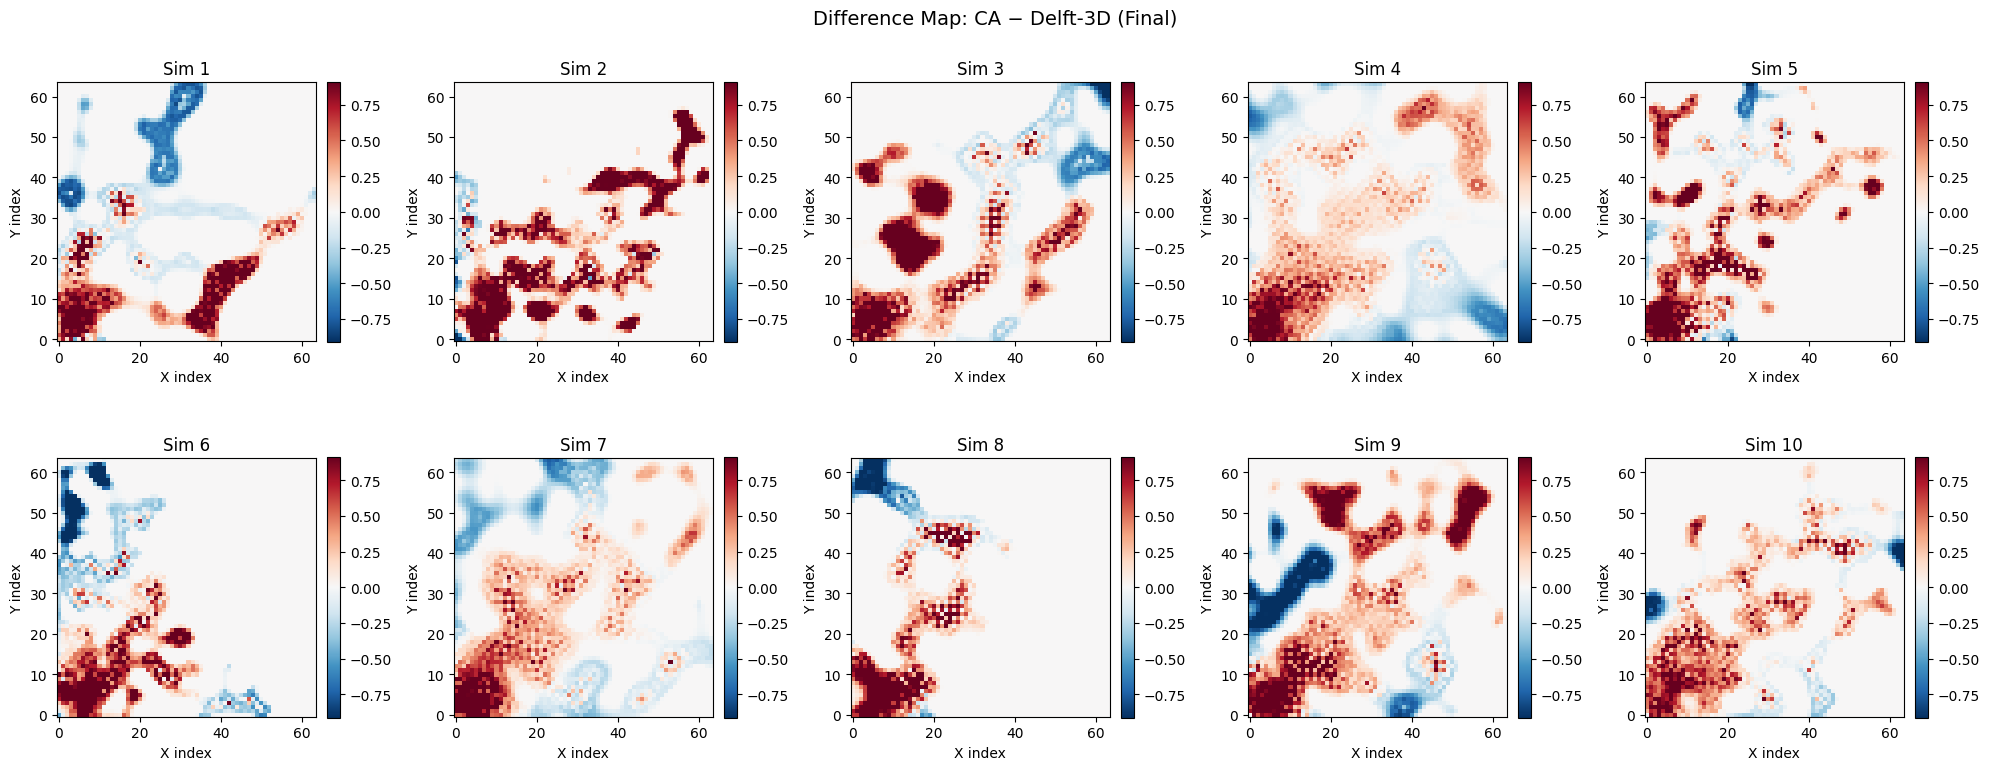

In [ ]:
# Running simulations from 1 to 10
sim_ids = list(range(1, 11))

dx = 100.0        #grid size (m)
t_end = 48 * 3600 #48 hours

results = run_batch_flood_pipeline(
    base_dir=base_dir,
    sim_ids=sim_ids,
    dx=dx,
    t_end=t_end,
    Q_in=50.0,
    n_manning=0.023,
    dt_max=30.0,
    plot_everything=True,
    ncols=5)

In [ ]:
import os, glob
# Replace 'MyProject.ipynb' with your actual file name
path = glob.glob('/content/drive/MyDrive/**/PyTorch_Batch_Parallelization_Final.ipynb', recursive=True)
print(path[0] if path else "File not found")


/content/drive/MyDrive/Colab Notebooks/PyTorch_Batch_Parallelization_Final.ipynb


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/PyTorch_Batch_Parallelization_Final.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/PyTorch_Batch_Parallelization_Final.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 1309376 bytes to /content/drive/MyDrive/Colab Notebooks/PyTorch_Batch_Parallelization_Final.html
